In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve, auc
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [2]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50
LR = 1e-4

DATASET_PATH = "/kaggle/input/datasets/sumaiyaakter4789/py-crackdb-1/Classification"

In [3]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(DATASET_PATH, transform=transform)

targets = dataset.targets

train_idx, val_idx = train_test_split(
    range(len(targets)),
    test_size=0.2,
    stratify=targets,
    random_state=42
)

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
weights = ResNet50_Weights.DEFAULT
resnet = resnet50(weights=weights)

# Freeze backbone
for param in resnet.parameters():
    param.requires_grad = False

# Replace final layer
resnet.fc = nn.Linear(resnet.fc.in_features, 1)
resnet = resnet.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 181MB/s] 


In [5]:
def train_model(model):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    start_time = time.time()

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.float().unsqueeze(1).to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{EPOCHS}] "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    train_time = time.time() - start_time

    history = {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_acc": train_accuracies,
        "val_acc": val_accuracies
    }

    return model, train_time, history

In [6]:
resnet, train_time, history = train_model(resnet)

Epoch [1/50] Train Loss: 0.6576 | Val Loss: 0.6495 | Train Acc: 0.6901 | Val Acc: 0.7368
Epoch [2/50] Train Loss: 0.6138 | Val Loss: 0.6045 | Train Acc: 0.7121 | Val Acc: 0.6930
Epoch [3/50] Train Loss: 0.5880 | Val Loss: 0.5783 | Train Acc: 0.6923 | Val Acc: 0.6754
Epoch [4/50] Train Loss: 0.5671 | Val Loss: 0.5569 | Train Acc: 0.6901 | Val Acc: 0.7018
Epoch [5/50] Train Loss: 0.5444 | Val Loss: 0.5404 | Train Acc: 0.6967 | Val Acc: 0.7281
Epoch [6/50] Train Loss: 0.5425 | Val Loss: 0.5405 | Train Acc: 0.7121 | Val Acc: 0.6930
Epoch [7/50] Train Loss: 0.5085 | Val Loss: 0.5223 | Train Acc: 0.7516 | Val Acc: 0.7544
Epoch [8/50] Train Loss: 0.4966 | Val Loss: 0.4963 | Train Acc: 0.7956 | Val Acc: 0.8070
Epoch [9/50] Train Loss: 0.4821 | Val Loss: 0.4921 | Train Acc: 0.7912 | Val Acc: 0.8070
Epoch [10/50] Train Loss: 0.4816 | Val Loss: 0.4639 | Train Acc: 0.8154 | Val Acc: 0.8333
Epoch [11/50] Train Loss: 0.4619 | Val Loss: 0.4651 | Train Acc: 0.8549 | Val Acc: 0.8246
Epoch [12/50] Train

In [7]:
def evaluate_model(model):
    model.eval()

    all_labels = []
    all_preds = []
    all_probs = []

    start_time = time.time()

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(int)

            all_labels.extend(labels.numpy())
            all_preds.extend(preds.flatten())
            all_probs.extend(probs.flatten())

    test_time = time.time() - start_time

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "cm": cm,
        "auc": roc_auc,
        "fpr": fpr,
        "tpr": tpr,
        "test_time": test_time
    }

resnet_metrics = evaluate_model(resnet)

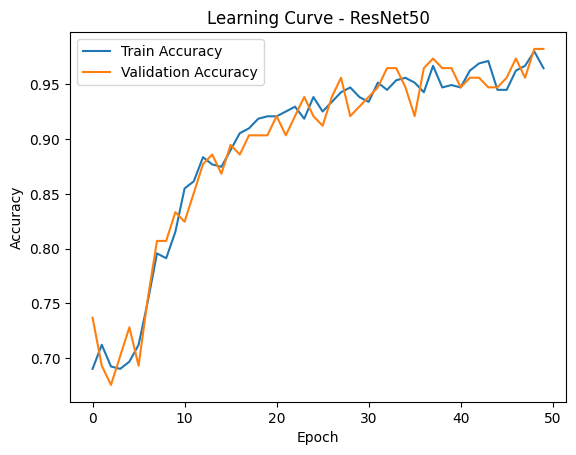

In [8]:
plt.figure()
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Learning Curve - ResNet50")
plt.legend()
plt.show()

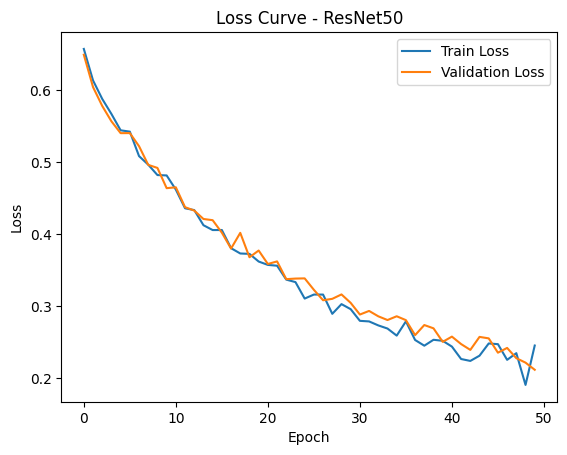

In [9]:
plt.figure()
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve - ResNet50")
plt.legend()
plt.show()

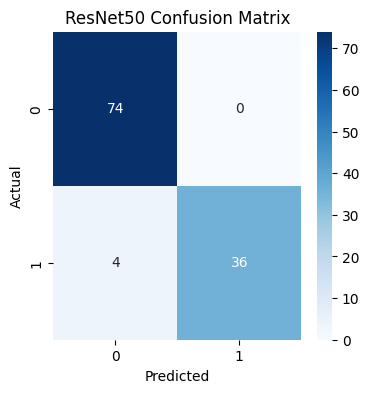

In [10]:
plt.figure(figsize=(4,4))
sns.heatmap(resnet_metrics["cm"], annot=True, fmt="d", cmap="Blues")
plt.title("ResNet50 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

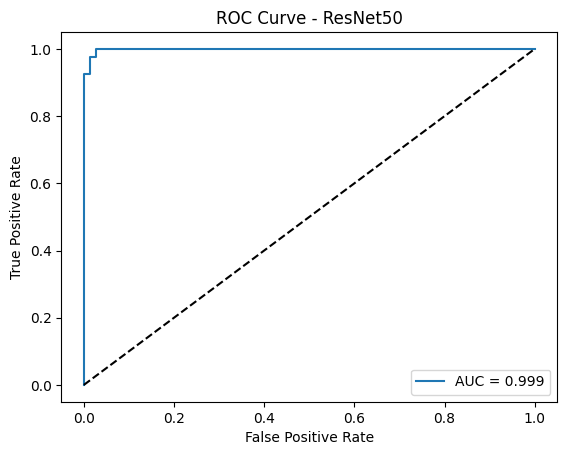

In [11]:
plt.figure()
plt.plot(resnet_metrics["fpr"], resnet_metrics["tpr"],
         label=f"AUC = {resnet_metrics['auc']:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - ResNet50")
plt.legend()
plt.show()

In [12]:
results = pd.DataFrame({
    "Model": ["ResNet50"],
    "Accuracy": [resnet_metrics["accuracy"]],
    "Precision": [resnet_metrics["precision"]],
    "Recall": [resnet_metrics["recall"]],
    "F1-Score": [resnet_metrics["f1"]],
    "AUC": [resnet_metrics["auc"]],
    "Training Time (s)": [train_time],
    "Testing Time (s)": [resnet_metrics["test_time"]]
})

results

,Model,Accuracy,Precision,Recall,F1-Score,AUC,Training Time (s),Testing Time (s)
0,ResNet50,0.964912,1.0,0.9,0.947368,0.998649,4509.331286,16.325011
